In [2]:
import numpy as np
#确保跟博主生成相同的随机数
np.random.seed(0)

In [3]:
#添加文件路径
X_train_fpath = './data/format/X_train'
Y_train_fpath = './data/format/Y_train'
X_test_fpath = './data/format/X_test'
output_fpath = 'E:/GitProjects/ML/LiHongYi-ML(2017)_my/0.HomeWork/HW2/output/output_{}.csv'	#用于测试集的预测输出

In [5]:
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

In [6]:
X_train

array([[7.75160e+04, 1.00000e+00, 2.17400e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.33110e+04, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.15646e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51910e+05, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.01490e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.87927e+05, 0.00000e+00, 1.50240e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [8]:
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n') for line in f], dtype = float)

In [9]:
Y_train

array([0., 0., 0., ..., 0., 0., 1.])

In [10]:
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

In [11]:
X_test

array([[2.26802e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.98140e+04, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.36951e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.74983e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.38910e+04, 1.00000e+00, 5.45500e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.82148e+05, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [12]:
#归一化
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        #为每个数据添加索值
        specified_column = np.arange(X.shape[1])
    if train:
        #求取每个数据的平均值和标准差
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1,-1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1,-1)
    #归一化数据
    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     #返回归一化后的数据，均值，标准差
    return X, X_mean, X_std

In [13]:
#分割训练集-验证集
def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [14]:
# 归一化数据
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [15]:
# 设置训练集-验证集
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 29304
Size of development set: 3257
Size of testing set: 16281
Dimension of data: 105


In [16]:
#打乱数据顺序，重新为minibatch分配
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

#sigmoid函数
def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))
#向前传播然后利用sigmoid激活函数计算激活值
def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

#预测
def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)

#准确度
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc
#交叉熵损失函数
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

#计算梯度值
def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [17]:
# 将w和b初始化为0
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# 设置其他超参数（迭代次数，分批次大小，学习率）  
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 创建列表用来保存训练集和验证集的损失值和准确度
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 用来更新学习率
step = 1

# 训练
for epoch in range(max_iter):
    # 每个epoch都会重新洗牌
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # 分批次训练
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # 计算梯度值
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # 更新参数w和b
        # 学习率随着迭代时间增加而减少
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
  	# 参数总共更新了max_iter × （train_size/batch_size）次     
    # 计算训练集的损失值和准确度
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
	# 计算验证集的损失值和准确度
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.32061854863510203
Development loss: 0.32598415582675705
Training accuracy: 0.8503958503958504
Development accuracy: 0.8483266809947805


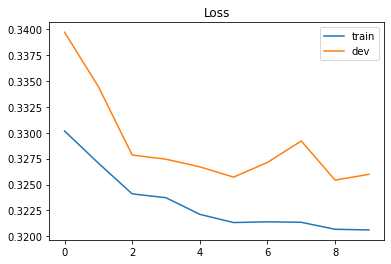

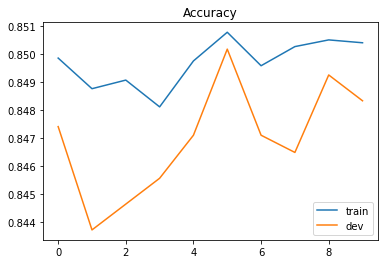

In [18]:
import matplotlib.pyplot as plt
#绘图
# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

In [19]:
#在测试集上进行预测
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

sex 2.313228901063884
 Married-AF-spouse 0.618113642136377
 Married-spouse-absent -0.5220928086248908
fnlwgt 0.4309004906180943
 Masters -0.43018883200659086
 Other-relative -0.42776806630004677
capital_loss 0.34194719722393085
 Unmarried 0.3206713508727994
 Assoc-voc 0.28393211412410424
capital_gain 0.281276025221092
